In [4]:
from pathlib import Path
import numpy as np
import pyart
import math
import copy

In [5]:

from prepro.nexrad import compute_nexrad_wave_form
from prepro.nexrad import prune_nexrad
from config import _EXAMPLEDATA_DIR

In [6]:
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KTLX20230227_012550_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KOAX20140603_213649_V06.gz')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KEWX20210504_020040_V06')
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KSHV20230613_230228_V06')
                            
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KFDR20200522_220109_V06')
radar_vol = pyart.io.read_nexrad_archive(filename)

In [7]:
elev_angles = radar_vol.fixed_angle['data'][:]
print('Elevations:', elev_angles)


Elevations: [ 0.3076172   0.3076172   0.48339844  0.48339844  0.87890625  0.87890625
  1.3183594   1.3183594   0.3076172   0.3076172   1.8017578   2.4169922
  3.1201172   3.9990234   5.0976562   6.4160156   7.998047   10.019531
 12.480469   15.600586   19.511719  ]


We have some random radar volume from above and our goal here is
to make a cappi of the Zdr data for a height of 5.5 km. First we need
to prune the data to doppler data, because ZDR data should use the doppler
collection mode and one elevation per volume

In [8]:
prune_actions = ['surv', 'volume']
#prune_actions = ['surv']

prune_vol = prune_nexrad(prune_actions, radar_vol)

In [9]:
##find the dictionary of the field we want:
moment_names = list(prune_vol.fields.keys())
print(moment_names)

mom_name = 'differential_reflectivity'

target_field = prune_vol.fields[mom_name]
print(target_field)

['reflectivity', 'clutter_filter_power_removed', 'cross_correlation_ratio', 'differential_phase', 'spectrum_width', 'velocity', 'differential_reflectivity']
{'units': 'dB', 'standard_name': 'log_differential_reflectivity_hv', 'long_name': 'log_differential_reflectivity_hv', 'valid_max': 7.9375, 'valid_min': -7.875, 'coordinates': 'elevation azimuth range', '_FillValue': -9999.0, 'data': masked_array(
  data=[[12.03125, 12.0, 11.9375, ..., --, --, --],
        [7.3125, 6.96875, 6.5625, ..., --, --, --],
        [1.65625, 1.5625, 1.25, ..., --, --, --],
        ...,
        [3.34375, 2.1875, 1.34375, ..., --, --, --],
        [1.5625, 1.5, 1.46875, ..., --, --, --],
        [8.0, 6.40625, 4.15625, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., 

We have a pruned volume and now we setup an empty pyart radial that we want to 
make into a CAPPI. 

At this point you can use any method to make a CAPPI from the pruned volume of data
We implemented this method because we used it before

In [10]:
cappi_target_height_m = 5500.0 #5.5km

num_gates = 1200
gate_spacing_m = 250.0

cappi_elev = 0.0
    
num_az = 360
az_spacing_deg = 1.0
az_offset = 0.5
    
cappi_azimuths = np.linspace(0, (num_az-1), num_az)*az_spacing_deg + az_offset
#print ('CAPPI azimuths: ', cappi_azimuths)
    
range_to_first_gate = radar_vol.range['data'][0]
#print ('Range_to_first: ', range_to_first_gate)

cappi_range = range_to_first_gate + np.linspace(0,(num_gates-1), num_gates)*gate_spacing_m
#print('CAPPI range: ', cappi_range)
    
cappi = pyart.testing.make_empty_ppi_radar(num_gates, num_az, 1)

#fixme go ahead and add all the other relevatant metadata 
#mostly because we want to be good citizens
cappi.time = prune_vol.time
cappi.metadata = prune_vol.metadata
cappi.lattidue = prune_vol.latitude
cappi.longitude = prune_vol.longitude
cappi.altitude = prune_vol.altitude
cappi.altitude_agl = prune_vol.altitude_agl

print ('altitude:', cappi.altitude, ' agl: ', cappi.altitude_agl)

cappi.fixed_angle["data"] = np.array([cappi_elev])
cappi.sweep_number["data"] = np.array([0])
cappi.sweep_start_ray_index["data"] = np.array([0])
cappi.sweep_end_ray_index["data"] = np.array([num_az-1])

cappi.azimuth['data'][:] = cappi_azimuths
cappi.range['data'][:] = cappi_range
cappi_data = np.empty( (num_az, num_gates), dtype='float32' )
cappi_data.fill(target_field["_FillValue"])
#cappi_data.where(0,  target_field["_FillValue"])
cappi_name = 'cappi_' + mom_name
cappi_dict = {
    "data": cappi_data,
    "units": target_field['units'],
    "long_name": 'cappi_'+target_field["long_name"],
    "_FillValue": target_field["_FillValue"],
    "standard_name": cappi_name
}
#print (cappi_dict)
cappi.add_field(cappi_name, cappi_dict)

work_data = np.empty( (num_az, num_gates), dtype='float32' )
work_data.fill(target_field["_FillValue"])
#let's go ahead and make the data storage forwork_data
working_dict = {
    "data": work_data,
    "units": target_field['units'],
    "long_name": 'work_data',
    "_FillValue": target_field["_FillValue"],
    "standard_name": 'work_data'
}
cappi.add_field('work_data', working_dict)

height_data = np.empty( (num_az, num_gates), dtype='float32' )
height_data.fill(target_field["_FillValue"])
#let's go ahead and make the data storage for cappi_height
height_dict = {
    "data": height_data,
    "units": 'meters AGL',
    "long_name": 'cappi_height',
    "_FillValue": target_field["_FillValue"],
    "standard_name": 'cappi_height'
}
cappi.add_field('cappi_height', height_dict)

   
#cappi.info()

altitude: {'long_name': 'Altitude', 'standard_name': 'Altitude', 'units': 'meters', 'positive': 'up', 'data': array([117.])}  agl:  None


Now the hard part where we iterate through the pyart object
which is sorted (important!) by elevation lowest elevation first and add the data
to a working_data and working_height array. When we encounter
data that spans the target height we compute the value of the cappi


In [11]:
#
#subroutine to find the nearest data index from the target index.
#
def findAzindex(target_az, azimuths):
    index = -1;
    min_diff = 1040.0
    for i in range(len(azimuths)):
        diff = target_az - azimuths[i]
        if diff > 180:
            diff -= 360
        if diff < -180:
            diff += 360
            
        diff = abs(diff)
        
        if diff < min_diff:
            min_diff = diff
            index = i;
            
    return index;

In [12]:


sweeps = prune_vol.sweep_number['data']
cappi_r2fg = cappi_range[0]
cappi_gate_spacing = cappi_range[1] - cappi_range[0]
max_cappi_dist = 0.3*cappi_target_height_m # the maximum distance in meters allowed between the target cappi height
                                     # and the actual height, should vary with height because radars have
                                     # wider vertical gaps aloft

#print(prune_vol.altitude['data'][:])
#we need the gate_z value later so
prune_vol.init_gate_x_y_z()
#print(prune_vol.gate_z['data'].shape)


missing_value = target_field["_FillValue"]
print('working...will notify at end')
for s in range(len(sweeps)):
    #if s > 4: break
    current_elev = prune_vol.fixed_angle['data'][s]
    print(s, 'current elev:', current_elev, 'cappi_elev', cappi_elev, 'start: ', prune_vol.get_start(s))
    #extract the current elevation range data
    #print(prune_vol.range['data'].shape)
    work_range = prune_vol.range['data']
    #print( work_range.shape)
    #convert the range for each bin in the current elevation to 
    #the range of the cappi angle (usually zero degrees)
    elev_diff = current_elev - cappi_elev
    conv_range = work_range * math.cos( math.radians(elev_diff))
    #print('conv_range:', conv_range[0:20])
    #if s == len(sweeps)-1:
    #    for i in range(len(conv_range)):
    #        print(i, work_range[i], conv_range[i])
    
    #we want to identify the index on the cappi where the current elev
    #would fall. There are probably multiple gates for higher elevations
    #that would fall into a single gate on a zero deg elev cappi. But the number
    #of gates is really quite low. You can try and average them if you want
    #but it's a waste of cycles.....If you get elevations higher than 20 Deg we
    #might want to average the data that has the same index. 
    conv_index = np.rint( (conv_range-cappi_r2fg)/cappi_gate_spacing).astype(int)
    #print('conv_index:', conv_index[0:20])
    
    #compute the AGL height along the radial for this elevation
    start_index, end_index = prune_vol.get_start_end(s)
    #print('start:', start_index, ' end_index: ', end_index)
    
    conv_height = prune_vol.gate_z['data'][start_index] 
    #print(start_index, 'conv_height: ', conv_height[0:20])
    
    #print the output for the last sweep because it has the most interesting output
    #if s == len(sweeps)-1:
    #    for i in range(len(conv_range)):
    #        print(i, work_range[i], conv_range[i], conv_index[i], conv_height[i])
 
    #we have all we need start reviewing the data computing the CAPPI
    #print(prune_vol.azimuth['data'].shape)
    
    cappi_az_index = 0
    for a in cappi.azimuth['data']:
        #print('working on cappi azimuth', a)
        #find the nearest data azimuth in this sweep.
        #print('shape',prune_vol.azimuth['data'][start_index:end_index].shape)
        data_az_index = findAzindex(a, prune_vol.azimuth['data'][start_index:end_index])
        data_az_index += start_index
        #
        #convert the input radial of data at the az_index to a matching cappi radial
        #using the computed index values above
        # The input radial data
        variable_data = prune_vol.fields[mom_name]['data'][data_az_index]
        #our target
        var_data = np.empty(num_gates, dtype='float32' )
        var_data.fill(missing_value)
        #
        var_height = np.empty(num_gates, dtype='float32' )
        var_height.fill(missing_value)
        #
        #Now loop through and add the data
        index = 0
        for d in variable_data:
            if index >= num_gates:
                break
            if np.isnan(d) == False:
                var_data[conv_index[index]] = d
            #always load height, never missing or nan (we hope)
            var_height[conv_index[index]] = conv_height[index] 
            index +=1
        #
        #Now we combine this data to the cappi if the height of the data looks right
        #
        #print('working on cappi azimuth', a, ' found azimuth: ', prune_vol.azimuth['data'][data_az_index], ' data_az_index: ', data_az_index)
        #print('found az_index:', data_az_index, 'az_diff:', a-prune_vol.azimuth['data'][data_az_index])
        cappi_radial = np.array(cappi.fields[cappi_name]['data'][cappi_az_index])
        #print(cappi_radial.shape)
        #print('missing:', missing_value)
        #print('fields: ', cappi.fields)
        #print('var_radial:', var_data[0:20])
        #print('var_height:', var_height[0:20])
        #print('cappi_radial: ', cappi_radial[0:20])
        cappi_work_data = np.array(cappi.fields['work_data']['data'][cappi_az_index])
        #print('cappi_work_data: ', cappi_work_data[0:20])
        cappi_height = np.array(cappi.fields['cappi_height']['data'][cappi_az_index])
        #if a >180 and a < 181:
        #    print('working on cappi azimuth', a, ' found azimuth: ', prune_vol.azimuth['data'][data_az_index], ' data_az_index: ', data_az_index)
        #    print('found az_index:', data_az_index, 'az_diff:', a-prune_vol.azimuth['data'][data_az_index])
        #    print('var_radial:', var_data[0:20])
        #    print('var_height:', var_height[0:20])
        #    print('cappi_radial: ', cappi_radial[0:20])
        #    print('cappi_height: ', cappi_height[0:20])
        #    print('cappi_work_data: ', cappi_work_data[0:20])
        
        #if(s==0):
        #   cappi_radial.fill(missing_value)
        #   cappi_work_data.fill(missing_value)
        #   cappi_height.fill(missing_value)
        
      
        for i in range(num_gates):
            #
            #an attempt to speed things up:
            if var_height[i] > (cappi_target_height_m + max_cappi_dist):
                break
            #find the first value of index i in conv_index
            #if i > 200 and i < 220 and a > 180 and a < 181:
            #    print('data', i, cappi_work_data[i], cappi_height[i])
            #    print('var:', i, var_data[i], var_height[i])
            #    print('cappi:', i, cappi_radial[i])
            #do not run if data index is invalid of cappi radial already has a value
           
            # and (np.isnan(variable_data[data_index])==False)
            #fill if missing
            if cappi_work_data[i] == missing_value:
                cappi_work_data[i] = var_data[i]
                    
            #fill if missing
            #if cappi_height[i] == missing_value:
            #    cappi_height[i] = var_height[i]
            
            #if cappi_radial[i] == missing_value and abs(var_height[i]-cappi_target_height_m) < max_cappi_dist:
            #    cappi_radial[i] = var_data[i]
            #    cappi_height[i] = var_height[i]
                
            #only estimate data if we haven't made an estimate at the proper height  
            if cappi_height[i] != cappi_target_height_m:     
                    
                #test to see if the heights span the cappi height you want:
                if cappi_height[i] < cappi_target_height_m and var_height[i] > cappi_target_height_m:
                    #and (var_height[i]-cappi_height[i])/2 < max_cappi_dist:    
                    #we have a span so linear interpolate the value between
                    if cappi_work_data[i] != missing_value and var_data[i] != missing_value:
                        cappi_radial[i] = cappi_work_data[i] + (cappi_target_height_m-cappi_height[i]) * \
                        (var_data[i]-cappi_work_data[i])/(var_height[i]-cappi_height[i])
                        #now we set the cappi_height to the value of cappi_target_height_m
                        #note that the if statement above will not execute on and =
                        cappi_height[i] = cappi_target_height_m
                        #if (a > 180 and a < 181):
                        #    print(i, cappi_work_data[i], cappi_radial[i], variable_data[i])
                        #    print(i, cappi_height[i], cappi_target_height_m, var_height[i])
                        
                elif cappi_height[i] < cappi_target_height_m and var_height[i] < cappi_target_height_m:
                #both the stored height and the new height are below the cappi_target_height_m
                #take the new height
                    if (cappi_target_height_m-var_height[i]) < max_cappi_dist:
                        cappi_radial[i] = var_data[i]
                        cappi_height[i] = var_height[i]
        #
        #push the arrays back into the object
        # note that we keep the latest version of var_data and var_var_height
        # but the computed version of cappi_radial
        cappi.fields[cappi_name]['data'][cappi_az_index] = copy.deepcopy(cappi_radial)
        cappi.fields['work_data']['data'][cappi_az_index] = copy.deepcopy(var_data)
        cappi.fields['cappi_height']['data'][cappi_az_index] = copy.deepcopy(cappi_height)
        cappi_az_index += 1
        
        #print('work_data:', cappi_work_data)
        

print('done...')

working...will notify at end
0 current elev: 0.3076172 cappi_elev 0.0 start:  0
1 current elev: 0.48339844 cappi_elev 0.0 start:  720
2 current elev: 0.87890625 cappi_elev 0.0 start:  1440
3 current elev: 1.3183594 cappi_elev 0.0 start:  2160
4 current elev: 1.8017578 cappi_elev 0.0 start:  2880
5 current elev: 2.4169922 cappi_elev 0.0 start:  3240
6 current elev: 3.1201172 cappi_elev 0.0 start:  3600
7 current elev: 3.9990234 cappi_elev 0.0 start:  3960
8 current elev: 5.0976562 cappi_elev 0.0 start:  4320
9 current elev: 6.4160156 cappi_elev 0.0 start:  4680
10 current elev: 7.998047 cappi_elev 0.0 start:  5040
11 current elev: 10.019531 cappi_elev 0.0 start:  5400
12 current elev: 12.480469 cappi_elev 0.0 start:  5760
13 current elev: 15.600586 cappi_elev 0.0 start:  6120
14 current elev: 19.511719 cappi_elev 0.0 start:  6480
done...


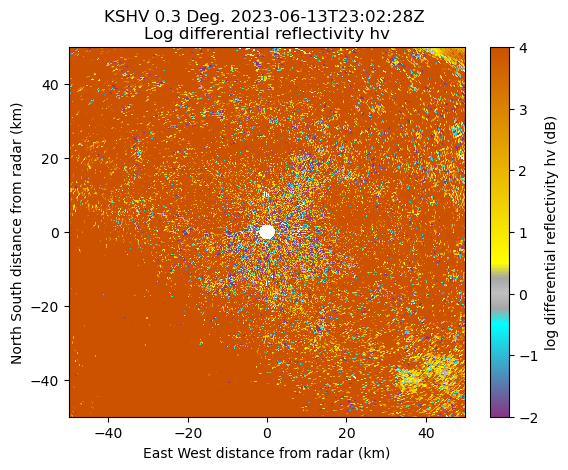

In [13]:
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_zdr_cmap
display = pyart.graph.RadarDisplay(prune_vol)

zdr_cmap = get_zdr_cmap(-2.0,4.0)

xlim = [-50, 50]
ylim = [-50, 50]

display.set_limits(xlim, ylim)

display.plot_ppi('differential_reflectivity', sweep=0, cmap=zdr_cmap, vmin=-2, vmax=4,)
plt.show()

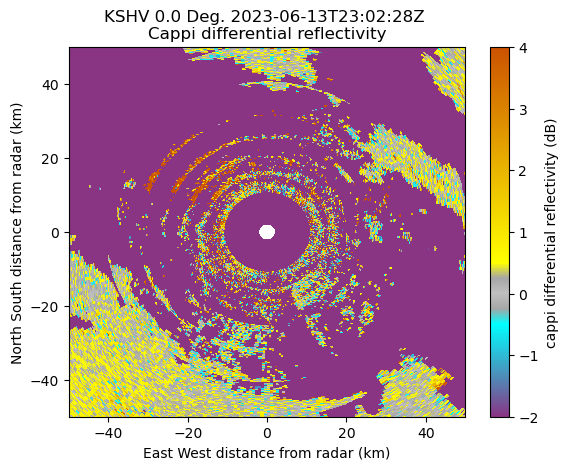

In [14]:
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_zdr_cmap
display = pyart.graph.RadarDisplay(cappi)

zdr_cmap = get_zdr_cmap(-2.0,4.0)

xlim = [-50, 50]
ylim = [-50, 50]

display.set_limits(xlim, ylim)

display.plot_ppi('cappi_differential_reflectivity', sweep=0, cmap=zdr_cmap, vmin=-2, vmax=4,)

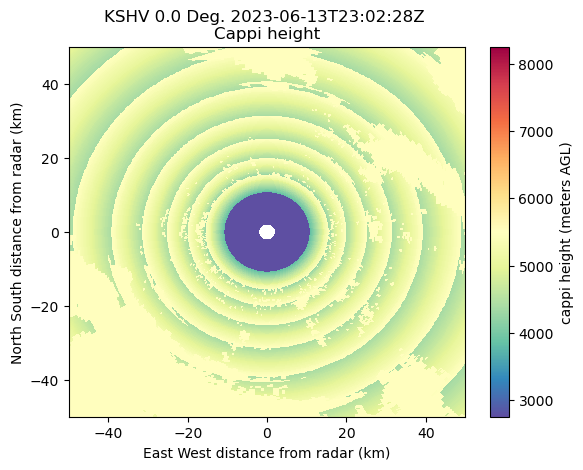

In [15]:
display.set_limits(xlim, ylim)

display.plot_ppi('cappi_height', sweep=0, vmin=cappi_target_height_m/2, vmax=cappi_target_height_m+cappi_target_height_m/2)
plt.show()

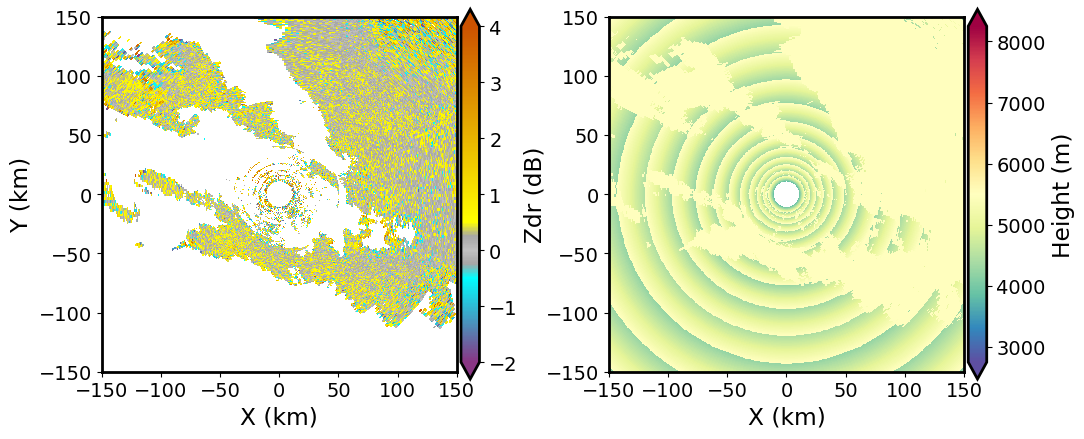

In [16]:
#viewable plots
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.2)
fig.set_facecolor("w")

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )


axislabels=["X (km)", "Y (km)"]
axisXlabels=["X (km)", ""]
axisYlabels=["", "Y (km)"]
axisnonelabels=["", ""]
xlim = [-150, 150]
ylim = [-150, 150]
xdiff = xlim[1]-xlim[0]
axps = xdiff *0.075
ayps = xdiff *0.025
aps = [xlim[0]+axps,ylim[0]+ayps]

sweep=0

display = pyart.graph.RadarDisplay(cappi)

ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')



display = pyart.graph.RadarDisplay(cappi)


display.set_limits(xlim, ylim, ax=ax1)

zdr_cmap = get_zdr_cmap(-2.0,4.0)
display.plot_ppi('cappi_differential_reflectivity', ax=ax1, sweep=0, cmap=zdr_cmap, vmin=-2, vmax=4,
        title_flag=False,colorbar_flag=False,mask_outside=True, axislabels=axislabels)
display.plot_colorbar(extend='both', pad=0.01, shrink=0.4, label='Zdr (dB)')


ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_ylabel('')
display.set_limits(xlim, ylim, ax=ax2)
display.plot_ppi('cappi_height', ax=ax2, sweep=0, vmin=cappi_target_height_m/2, vmax=cappi_target_height_m+cappi_target_height_m/2,
        title_flag=False,colorbar_flag=False,mask_outside=True, axislabels=axisXlabels)
display.plot_colorbar(extend='both', pad=0.01, shrink=0.4, label='Height (m)')
plt.show()

out_filename = Path("./test.png")
fig.savefig(out_filename)
plt.close(fig)

